In [39]:
%matplotlib inline
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Eclipse Adoptium\\jdk-8.0.452.9-hotspot"
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DiabetesPrediction") \
    .getOrCreate()

print("Spark 启动成功")


Spark 启动成功


In [68]:
df = spark.read.csv("diabetes.csv",header=True, inferSchema = True)

df.show(5)


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [69]:
from pyspark.sql.functions import when

# 数据清理
columns_to_clean = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in columns_to_clean:
    df = df.withColumn(col, when(df[col] == 0, None).otherwise(df[col]))

df_clean = df.dropna()

# 查看剩余记录数
print("清洗后剩余行数：", df_clean.count())

# 再确认所有字段都是数值型
df_clean.printSchema()


清洗后剩余行数： 392
root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [70]:
from pyspark.ml.feature import VectorAssembler

# 除了 Outcome是标签，其他都是特征
feature_cols = [c for c in df_clean.columns if c != "Outcome"]

# 用 VectorAssembler 合并特征列
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df_clean)

# 展示新生成的 features 向量
data.select("features", "Outcome").take(5)


[Row(features=DenseVector([1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0]), Outcome=0),
 Row(features=DenseVector([0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 33.0]), Outcome=1),
 Row(features=DenseVector([3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248, 26.0]), Outcome=1),
 Row(features=DenseVector([2.0, 197.0, 70.0, 45.0, 543.0, 30.5, 0.158, 53.0]), Outcome=1),
 Row(features=DenseVector([1.0, 189.0, 60.0, 23.0, 846.0, 30.1, 0.398, 59.0]), Outcome=1)]

In [71]:
# 8-2分，八分训练两分测试
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

print("训练集：", train_data.count())
print("测试集：", test_data.count())



训练集： 335
测试集： 57


In [72]:
from pyspark.ml.classification import LogisticRegression

# 初始化逻辑回归模型
lr = LogisticRegression(labelCol="Outcome", featuresCol="features")

# 训练
model = lr.fit(train_data)

# 模型结构信息
print("训练完成")
print("模型系数（每个特征的影响权重）：")
print(model.coefficients)
print("截距项：", model.intercept)


训练完成
模型系数（每个特征的影响权重）：
[0.08786185922943177,0.041002438581139306,-0.0025679078356106977,0.01040229633307788,-0.0012186274118428234,0.08335328212509667,1.1197752041228461,0.03234739464160468]
截距项： -10.609041690169043


In [73]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 进行预测
predictions = model.transform(test_data)

# 创建评估器
evaluator = BinaryClassificationEvaluator(
    labelCol="Outcome", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)

# 计算 AUC
auc = evaluator.evaluate(predictions)
print(f"ROC-AUC Score: {auc:.4f}")


ROC-AUC Score: 0.8421


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_25624\3543162371.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x="Outcome", palette="Set2")


<Figure size 640x480 with 0 Axes>

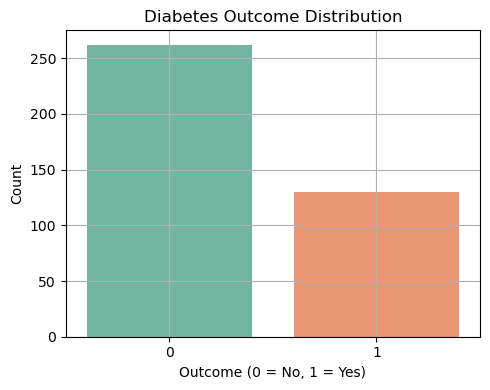

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pandas_df = df_clean.toPandas()




plt.figure(figsize=(5,4))
sns.countplot(data=pandas_df, x="Outcome", palette="Set2")
plt.title("Diabetes Outcome Distribution")
plt.xlabel("Outcome (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("Diabetes Outcome Distribution.png")

C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_25624\4017637203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pandas_df, x="Outcome", y="Age", palette="coolwarm")


<Figure size 640x480 with 0 Axes>

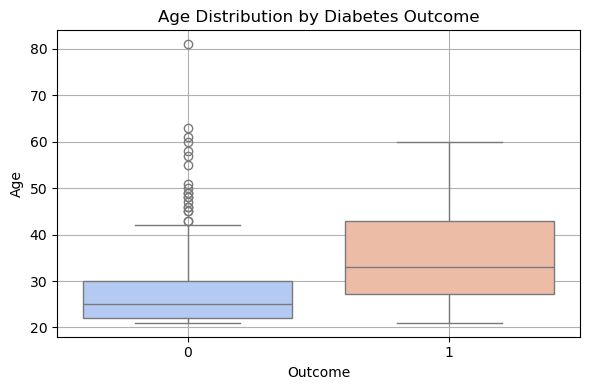

In [75]:
plt.figure(figsize=(6,4))
sns.boxplot(data=pandas_df, x="Outcome", y="Age", palette="coolwarm")
plt.title("Age Distribution by Diabetes Outcome")
plt.xlabel("Outcome")
plt.ylabel("Age")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_25624\79674875.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pandas_df, x="Outcome", y="BMI", palette="pastel")


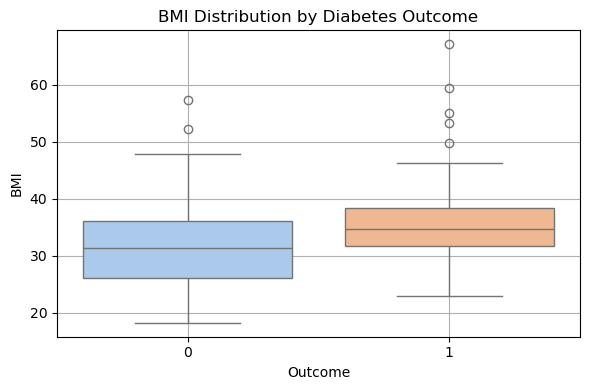

In [76]:
plt.figure(figsize=(6,4))
sns.boxplot(data=pandas_df, x="Outcome", y="BMI", palette="pastel")
plt.title("BMI Distribution by Diabetes Outcome")
plt.xlabel("Outcome")
plt.ylabel("BMI")
plt.grid(True)
plt.tight_layout()
plt.show()


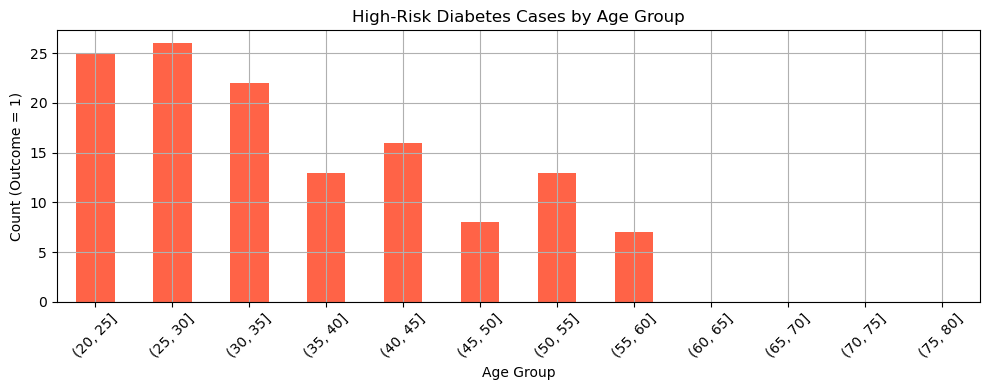

In [77]:
bins = list(range(20, 81, 5))
pandas_df["age_group"] = pd.cut(pandas_df["Age"], bins=bins)
high_risk_ages = pandas_df[pandas_df["Outcome"] == 1]["age_group"].value_counts().sort_index()

plt.figure(figsize=(10,4))
high_risk_ages.plot(kind="bar", color="tomato")
plt.title("High-Risk Diabetes Cases by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count (Outcome = 1)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("high_risk_by_age_group.png")


<Figure size 640x480 with 0 Axes>

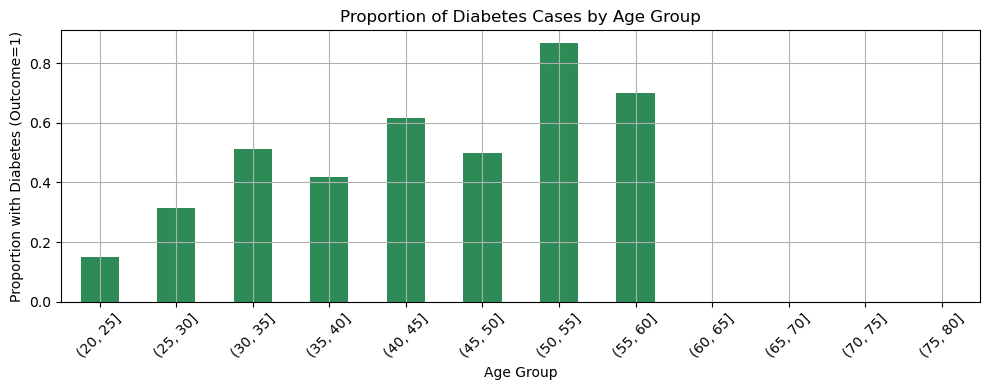

In [78]:
bins = list(range(20, 81, 5))
pandas_df["age_group"] = pd.cut(pandas_df["Age"], bins=bins)
# 每个年龄段总人数
age_total = pandas_df["age_group"].value_counts().sort_index()

# 每个年龄段中患病人数（Outcome=1）
age_positive = pandas_df[pandas_df["Outcome"] == 1]["age_group"].value_counts().sort_index()
age_risk_rate = (age_positive / age_total).fillna(0)

plt.figure(figsize=(10, 4))
age_risk_rate.plot(kind="bar", color="seagreen")
plt.title("Proportion of Diabetes Cases by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Proportion with Diabetes (Outcome=1)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

